In [1]:
!pip install scipy matplotlib statsmodels sklearn seaborn

In [2]:
import atoti as tt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from atoti.config import create_config
from sklearn import preprocessing
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests, pacf

Welcome to atoti 0.4.3!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [3]:
coins = [
    "BTC",
    "ETH",
    "XRP",
    "USDT",
    "BCH",
    "ADA",
    "BSV",
    "LTC",
    "LINK",
    "BNB",
    "EOS",
    "TRON",
]

In [4]:
currency_metrics = pd.read_csv(
    "https://data.atoti.io/notebooks/twitter/tweets_metrics_full.csv"
)
currency_metrics.head()

,coin_symbol,date,Tweet volume,Retweet total,Retweet average,Followers total,Followers average,Favorite total,Favorite average,Polarity total,Polarity average,Negative,Neutral,Positive,Bullish ratio
0,ADA,2019-12-08,99,438,4.424242,202427,2044.717172,1001,10.111111,17.572090,0.177496,7.0,50.0,42.0,6.000000
1,ADA,2019-12-09,120,175,1.458333,410814,3423.450000,506,4.216667,11.616706,0.096806,13.0,64.0,43.0,3.307692
2,ADA,2019-12-10,129,239,1.852713,1038600,8051.162791,983,7.620155,15.501187,0.120164,12.0,64.0,53.0,4.416667
3,ADA,2019-12-11,103,151,1.466019,303994,2951.398058,687,6.669903,10.941811,0.106231,14.0,50.0,39.0,2.785714
4,ADA,2019-12-12,104,452,4.346154,811656,7804.384615,1075,10.336538,6.248597,0.060083,11.0,60.0,33.0,3.000000


In [5]:
currency_price = pd.read_csv("https://data.atoti.io/notebooks/twitter/prices.csv")
currency_price.head()

,coin_symbol,date,Price,Returns
0,ADA,2019-12-08,0.038431,0.000279
1,ADA,2019-12-09,0.038669,0.000238
2,ADA,2019-12-10,0.037371,-0.001297
3,ADA,2019-12-11,0.036405,-0.000966
4,ADA,2019-12-12,0.036541,0.000136


### Preprocessing

In [6]:
currency_df = pd.merge(
    currency_price, currency_metrics, on=["coin_symbol", "date"]
).drop(columns=["Negative", "Neutral", "Positive"])
currency_df.head()

,coin_symbol,date,Price,Returns,Tweet volume,Retweet total,Retweet average,Followers total,Followers average,Favorite total,Favorite average,Polarity total,Polarity average,Bullish ratio
0,ADA,2019-12-08,0.038431,0.000279,99,438,4.424242,202427,2044.717172,1001,10.111111,17.572090,0.177496,6.000000
1,ADA,2019-12-09,0.038669,0.000238,120,175,1.458333,410814,3423.450000,506,4.216667,11.616706,0.096806,3.307692
2,ADA,2019-12-10,0.037371,-0.001297,129,239,1.852713,1038600,8051.162791,983,7.620155,15.501187,0.120164,4.416667
3,ADA,2019-12-11,0.036405,-0.000966,103,151,1.466019,303994,2951.398058,687,6.669903,10.941811,0.106231,2.785714
4,ADA,2019-12-12,0.036541,0.000136,104,452,4.346154,811656,7804.384615,1075,10.336538,6.248597,0.060083,3.000000


In [7]:
currency_df.isnull().sum()

coin_symbol          0
date                 0
Price                0
Returns              0
Tweet volume         0
Retweet total        0
Retweet average      0
Followers total      0
Followers average    0
Favorite total       0
Favorite average     0
Polarity total       0
Polarity average     0
Bullish ratio        0
dtype: int64

In [8]:
currency_df = currency_df.dropna()
currency_df.isnull().sum()

coin_symbol          0
date                 0
Price                0
Returns              0
Tweet volume         0
Retweet total        0
Retweet average      0
Followers total      0
Followers average    0
Favorite total       0
Favorite average     0
Polarity total       0
Polarity average     0
Bullish ratio        0
dtype: int64

In [9]:
coins_metrics = currency_df.set_index(["coin_symbol", "date"]).columns.to_list()
coins_metrics

['Price',
 'Returns',
 'Tweet volume',
 'Retweet total',
 'Retweet average',
 'Followers total',
 'Followers average',
 'Favorite total',
 'Favorite average',
 'Polarity total',
 'Polarity average',
 'Bullish ratio']

In [10]:
data_stats = pd.DataFrame(
    columns=[
        "coin_symbol",
        "metric_name",
        "norm_stat",
        "norm_p",
        "kurtosis",
        "skewness",
        "lag_acf",
        "lag_pacf",
        "std",
        "durbin_watson",
    ]
)

for coin in coins:
    coin_df = currency_df.loc[currency_df["coin_symbol"] == coin]
    for metric_name in coins_metrics:
        # normal distribution check
        metric = coin_df[metric_name]
        stat, p = stats.normaltest(metric)
        kurtosis = stats.kurtosis(metric)
        skewness = stats.skew(metric)

        # autocorrelation
        lag_acf = ";".join(map(str, acf(metric, nlags=50).tolist()))
        lag_pacf = ";".join(map(str, pacf(metric, nlags=50, method="ols").tolist()))

        data_stats = data_stats.append(
            {
                "coin_symbol": coin,
                "metric_name": metric_name,
                "norm_stat": stat,
                "norm_p": p,
                "kurtosis": kurtosis,
                "skewness": skewness,
                "lag_acf": lag_acf,
                "lag_pacf": lag_pacf,
                "std": metric.std(),
                "durbin_watson": np.nan,
            },
            ignore_index=True,
        )

data_stats.head()

C:\Apps\miniconda3\envs\atoti-20201005\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


,coin_symbol,metric_name,norm_stat,norm_p,kurtosis,skewness,lag_acf,lag_pacf,std,durbin_watson
0,BTC,Price,5.736011,5.681212e-02,-0.226774,-0.343432,1.0;0.9777329292107778;0.956838790568574;0.932...,1.0;0.9802484187271252;0.034347306191366556;-0...,1.575599e+03,NaN
1,BTC,Returns,221.228609,9.137299e-49,27.435333,-2.860426,1.0;-0.04289755604445967;0.0912468942047658;-0...,1.0;-0.0428991632004459;0.08955684137955391;-0...,3.014460e+02,NaN
2,BTC,Tweet volume,159.966873,1.834995e-35,6.797124,2.559059,1.0;0.8717491114144025;0.7699720684339101;0.73...,1.0;0.8729623006429926;0.024851516571685137;0....,5.277166e+03,NaN
3,BTC,Retweet total,202.766718,9.327530e-45,10.084647,3.238258,1.0;0.8952266582521369;0.7925279789805152;0.71...,1.0;0.8956075446910358;-0.05717796283992777;0....,4.829454e+06,NaN
4,BTC,Retweet average,209.497673,3.222243e-46,10.993250,3.329554,1.0;0.9113750013514399;0.8156034386119618;0.74...,1.0;0.9117620925425851;-0.10863490345856888;0....,2.793805e+02,NaN


### Data loading into atoti

Let's load the original metrics into the atoti cube.

In [11]:
config = create_config(metadata_db="./metadata.db")
session = tt.create_session(config=config)

In [12]:
price_store = session.read_pandas(
    currency_price, keys=["coin_symbol", "date"], store_name="currency price"
)

In [13]:
metrics_store = session.read_pandas(
    currency_metrics,
    keys=["coin_symbol", "date"],
    store_name="metrics",
    types={
        "Tweet volume": tt.types.FLOAT,
        "Retweet total": tt.types.FLOAT,
        "Retweet average": tt.types.FLOAT,
        "Followers total": tt.types.FLOAT,
        "Followers average": tt.types.FLOAT,
        "Favorite total": tt.types.FLOAT,
        "Favorite average": tt.types.FLOAT,
        "Polarity total": tt.types.FLOAT,
        "Polarity average": tt.types.FLOAT,
        "Negative": tt.types.FLOAT,
        "Neutral": tt.types.FLOAT,
        "Positive": tt.types.FLOAT,
        "Bullish ratio": tt.types.FLOAT,
    },
)
metrics_store.head()

Tweet volume  Retweet total  Retweet average  \
coin_symbol date                                                       
ADA         2019-12-08          99.0          438.0         4.424243   
            2019-12-09         120.0          175.0         1.458333   
            2019-12-10         129.0          239.0         1.852713   
            2019-12-11         103.0          151.0         1.466019   
            2019-12-12         104.0          452.0         4.346154   

                        Followers total  Followers average  Favorite total  \
coin_symbol date                                                             
ADA         2019-12-08         202427.0          2044.7172          1001.0   
            2019-12-09         410814.0          3423.4500           506.0   
            2019-12-10        1038600.0          8051.1626           983.0   
            2019-12-11         303994.0          2951.3980           687.0   
            2019-12-12         811656.0          7804.3850          1075.0   

                        Favorite average  Polarity total  Polarity average  \
coin_symbol date                                                             
ADA         2019-12-08         10.111111       17.572090          0.177496   
            2019-12-09          4.216667       11.616706          0.096806   
            2019-12-10          7.620155       15.501187          0.120164   
            2019-12-11          6.669903       10.941811          0.106231   
            2019-12-12         10.336538        6.248597          0.060083   

                        Negative  Neutral  Positive  Bullish ratio  
coin_symbol date                                                    
ADA         2019-12-08       7.0     50.0      42.0       6.000000  
            2019-12-09      13.0     64.0      43.0       3.307692  
            2019-12-10      12.0     64.0      53.0       4.416666  
            2019-12-11      14.0     50.0      39.0       2.785714  
            2019-12-12      11.0     60.0      33.0       3.000000

In [14]:
currency_store = session.read_csv(
    "s3://data.atoti.io/notebooks/twitter/currency_dict.csv",
    keys=["coin_symbol"],
    store_name="currency",
)
currency_store.head()

,currency_name
coin_symbol,
ADA,cardano
BCH,bitcoin-cash
BNB,binancecoin
BSV,bitcoin-cash-sv
BTC,bitcoin


In [15]:
stats_store = session.read_pandas(
    data_stats,
    keys=["coin_symbol", "metric_name"],
    store_name="statistics",
    types={"lag_acf": tt.types.FLOAT_ARRAY, "lag_pacf": tt.types.FLOAT_ARRAY},
    array_sep=";",
)
stats_store.head()

norm_stat        norm_p   kurtosis  skewness  \
coin_symbol metric_name                                                      
BTC         Price              5.736011  5.681212e-02  -0.226774 -0.343432   
            Returns          221.228609  9.137299e-49  27.435333 -2.860426   
            Tweet volume     159.966873  1.834995e-35   6.797124  2.559059   
            Retweet total    202.766718  9.327530e-45  10.084647  3.238258   
            Retweet average  209.497673  3.222243e-46  10.993250  3.329554   

                                               lag_acf  \
coin_symbol metric_name                                  
BTC         Price            floatVector[51]{1.0, ...}   
            Returns          floatVector[51]{1.0, ...}   
            Tweet volume     floatVector[51]{1.0, ...}   
            Retweet total    floatVector[51]{1.0, ...}   
            Retweet average  floatVector[51]{1.0, ...}   

                                              lag_pacf           std  \
coin_symbol metric_name                                                
BTC         Price            floatVector[51]{1.0, ...}  1.575599e+03   
            Returns          floatVector[51]{1.0, ...}  3.014460e+02   
            Tweet volume     floatVector[51]{1.0, ...}  5.277166e+03   
            Retweet total    floatVector[51]{1.0, ...}  4.829454e+06   
            Retweet average  floatVector[51]{1.0, ...}  2.793805e+02   

                             durbin_watson  
coin_symbol metric_name                     
BTC         Price                      NaN  
            Returns                    NaN  
            Tweet volume               NaN  
            Retweet total              NaN  
            Retweet average            NaN

In [16]:
price_store.join(metrics_store)
price_store.join(stats_store)
metrics_store.join(currency_store)

In [17]:
cube = session.create_cube(price_store, name="Cryptocurrency cube", mode="manual")

In [18]:
cube

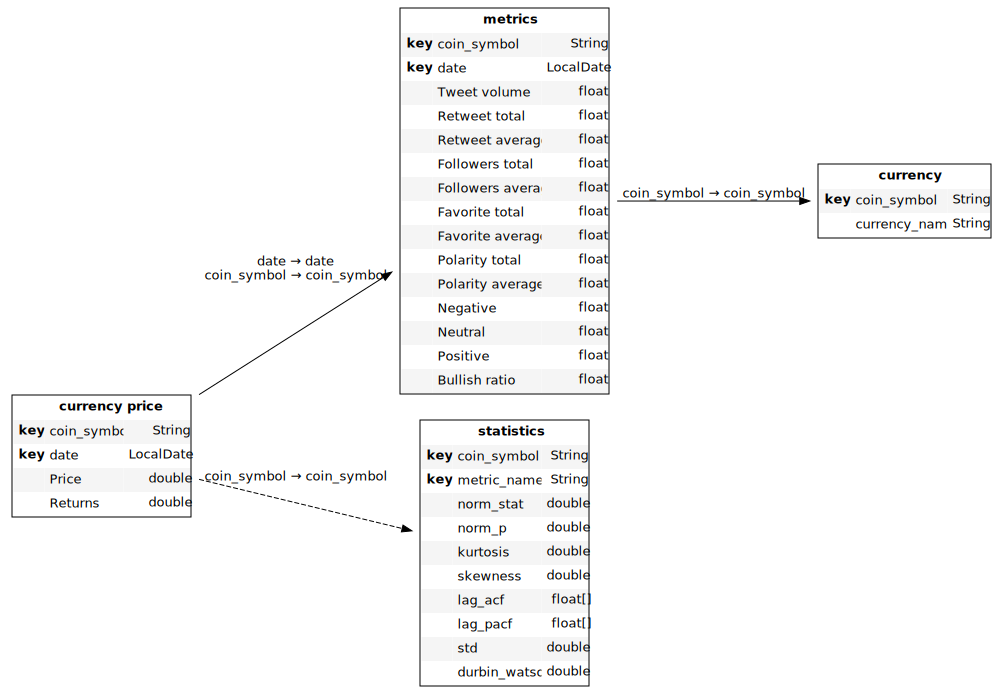

In [19]:
cube.schema

In [20]:
h = cube.hierarchies
l = cube.levels
m = cube.measures

In [21]:
h["Coin Symbol"] = [metrics_store["coin_symbol"], currency_store["currency_name"]]
h["Coin Symbol"].dimension = "Cryptocurrency"
h["Coin Symbol"].slicing = True

h["Date"] = [metrics_store["date"]]
h["Date"].dimension = "Time-series"

h["metric_name"].dimension = "Metrics"

In [22]:
h

Hierarchies()

In [23]:
m["Tweet volume"] = tt.agg.sum(metrics_store["Tweet volume"])
m["Retweet total"] = tt.agg.sum(metrics_store["Retweet total"])
m["Followers total"] = tt.agg.sum(metrics_store["Followers total"])
m["Favorite total"] = tt.agg.sum(metrics_store["Favorite total"])
m["Polarity total"] = tt.agg.sum(metrics_store["Polarity total"])
m["Negative"] = tt.agg.sum(metrics_store["Negative"])
m["Neutral"] = tt.agg.sum(metrics_store["Neutral"])
m["Positive"] = tt.agg.sum(metrics_store["Positive"])

In [24]:
m["Retweet average"] = tt.agg.mean(metrics_store["Retweet average"])
m["Followers average"] = tt.agg.mean(metrics_store["Followers average"])
m["Favorite average"] = tt.agg.mean(metrics_store["Favorite average"])
m["Polarity average"] = tt.agg.mean(metrics_store["Polarity average"])

m["Price"] = tt.agg.mean(price_store["Price"])
m["Returns"] = tt.agg.mean(price_store["Returns"])

In [25]:
m["Bullish ratio"] = m["Positive"] / m["Negative"]

In [26]:
metrics_folder = "metrics"
m["Tweet volume"].folder = metrics_folder
m["Retweet total"].folder = metrics_folder
m["Followers total"].folder = metrics_folder
m["Favorite total"].folder = metrics_folder
m["Polarity total"].folder = metrics_folder
m["Negative"].folder = metrics_folder
m["Neutral"].folder = metrics_folder
m["Positive"].folder = metrics_folder
m["Retweet average"].folder = metrics_folder
m["Followers average"].folder = metrics_folder
m["Favorite average"].folder = metrics_folder
m["Polarity average"].folder = metrics_folder
m["Price"].folder = metrics_folder
m["Returns"].folder = metrics_folder
m["Bullish ratio"].folder = metrics_folder

In [27]:
l["coin_symbol"].comparator = tt.comparator.first_members(coins)

In [28]:
cube.visualize("Default slicing member ordering updated")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

### Normal Distribution Check

In [29]:
m["norm_stat"] = tt.agg.mean(stats_store["norm_stat"])
m["norm_p"] = tt.agg.mean(stats_store["norm_p"])
m["kurtosis"] = tt.agg.mean(stats_store["kurtosis"])
m["skewness"] = tt.agg.mean(stats_store["skewness"])
m["std"] = tt.agg.mean(stats_store["std"])
m["durbin_watson"] = tt.agg.mean(stats_store["durbin_watson"])

m["norm_stat"].formatter = "DOUBLE[#,###.0000]"
m["norm_p"].formatter = "DOUBLE[#,###.0000]"
m["kurtosis"].formatter = "DOUBLE[#,###.0000]"
m["skewness"].formatter = "DOUBLE[#,###.0000]"
m["std"].formatter = "DOUBLE[#,###.0000]"
m["durbin_watson"].formatter = "DOUBLE[#,###.0000]"

In [30]:
m["lag_acf"] = tt.agg.mean(stats_store["lag_acf"])
m["lag_pacf"] = tt.agg.mean(stats_store["lag_pacf"])

In [31]:
stats_folder = "Statistics"
m["norm_stat"].folder = stats_folder
m["norm_p"].folder = stats_folder
m["kurtosis"].folder = stats_folder
m["skewness"].folder = stats_folder
m["std"].folder = stats_folder
m["durbin_watson"].folder = stats_folder
m["lag_acf"].folder = stats_folder
m["lag_pacf"].folder = stats_folder

In [32]:
cube.visualize("Bit coin metrics statistics")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

if p-value is less than or equal to 0.05 (at 95% confidence level), we will reject the null hypothesis below.

- Null hypothesis: Data looks Gaussian
- Alternative hypothesis: Data looks non-Gaussian

In [33]:
m["Gaussian confidence"] = 0.05
m["Distribution type"] = tt.where(
    m["norm_p"] > m["Gaussian confidence"], "Gaussian", "Non-Gaussian"
)

dist_folder = "Distribution"
m["Gaussian confidence"].folder = dist_folder
m["Distribution type"].folder = dist_folder

In [34]:
cube.visualize("Distribution type of the time-series for each metric of the currency")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

Kurtosis value of less than -1 shows that the distribution is too flat while a value greater than 1 is too peaked.  
Skewness value between -0.5 and 0.5 shows that data are pretty symmetrical. Values between -1 and -0.5, or between 0.5 and 1, shows that data are moderately skewed. Otherwise, the data are highly skewed. 

In [36]:
cube.visualize("Distribution stats")

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

The kurtosis values showed that the distributions are all either too peaked (> 1, fat tail - profusion of outliers) or too fat (< -1, lack of outliers).  
Only a few such as the BTC's value and Folloers average are normal distributed based on the skewness value.

In [ ]:
cube.create_parameter_hierarchy(
    "Lags",
    list(range(50)),
    index_measure="Lag Index",
)

In [ ]:
m["acf"] = m["lag_acf"][m["Lag Index"]]
m["acf"].formatter = "DOUBLE[#,###.0000]"

m["pacf"] = m["lag_pacf"][m["Lag Index"]]
m["pacf"].formatter = "DOUBLE[#,###.0000]"

In [ ]:
# https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
# https://en.wikipedia.org/wiki/1.96#:~:text=95%25%20of%20the%20area%20under%20a%20normal%20curve%20lies%20within,of%20approximate%2095%25%20confidence%20intervals.
# https://www.statisticshowto.com/probability-and-statistics/find-critical-values/#CommonCI
m["critical value"] = 1.96
m["Upper 95% confidence level"] = m["critical value"] / tt.sqrt(m["contributors.COUNT"])
m["Lower 95% confidence level"] = -m["critical value"] / tt.sqrt(
    m["contributors.COUNT"]
)

See the ACF and PACF for Bitcoin price time-series.  
There is a good positive correlation with lags up to 39 lags where `acf` cuts the upper confidence level.  
After 2 lags, PACF cuts the upper confidence level.

In [ ]:
cube.visualize("Auto-correlation for BTC price")

For XRP, we see positive and negative auto-correlation.

In [ ]:
cube.visualize("Auto-correlation for XRP price")

A stationary process has the property that the mean, variance and autocorrelation structure do not change over time.  
Let's apply transformation to make the time-series stationary.

In [ ]:
metrics_df = cube.query(
    m["Price"],
    m["Returns"],
    m["Tweet volume"],
    m["Retweet total"],
    m["Retweet average"],
    m["Followers total"],
    m["Followers average"],
    m["Favorite total"],
    m["Favorite average"],
    m["Polarity total"],
    m["Polarity average"],
    m["Bullish ratio"],
    levels=[l["coin_symbol"], l["date"]],
)

metrics_df.head()

In [ ]:
# https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/margin-of-error/#:~:text=The%20margin%20of%20error%20can,Standard%20error%20of%20the%20sample.
m["margin of error"] = m["critical value"] * (
    m["std"] / tt.sqrt(m["contributors.COUNT"])
)

In [ ]:
# # https://towardsdatascience.com/how-do-you-know-you-have-enough-training-data-ad9b1fd679ee
# training_size = ((1.96 * 0.036105) / (0.036105 * 0.20)) ** 2
# round(training_size)

# m["Training size1"] = (m["critical value"]*m["std"])/m["margin of error"]
m["Training size"] = tt.round(tt.sqrt(m["contributors.COUNT"]))

In [ ]:
training_size_df = cube.query(m["Training size"], levels=[l["coin_symbol"]])
training_size_df.head()

### Time-series stationary checking  


In [ ]:
session.url + "/#/dashboard/44e"

In [ ]:
diff_col = metrics_df.reset_index().columns.to_list()
diff_col.append("order")
diff_col

In [ ]:
# full_diff_df = pd.DataFrame(columns=diff_col).set_index(
#     ["coin_symbol", "date", "order"]
# )

# https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/
def augmented_dickey_fuller_statistics(
    coin, metric_name, time_series, diff_order, _diff
):
    global full_diff_df
    result = adfuller(time_series)
    if result[1] < 0.05:
        # no differencing required
        #         print(coin, metric_name, "No unit root (Reject null hypothesis)")
        return _diff, time_series
    else:
        print(coin, metric_name, "p-value: %f" % result[1])
        print(
            coin,
            metric_name,
            "There is unit root (Cannot reject null hypothesis) - Repeat differencing",
        )

        diff_order += 1
        differencing = time_series.diff()

        diff_df = differencing.reset_index()
        diff_df["order"] = diff_order
        diff_df.set_index(["coin_symbol", "date", "order"], inplace=True)
        #         print(diff_order, metric_name, "============= diff_df", diff_df)
        #         print(metric_name, "============= _diff", _diff)
        axis = 1 if metric_name in diff_df.columns else 0
        _diff = pd.concat([_diff, diff_df], axis=axis, join="outer")

        return augmented_dickey_fuller_statistics(
            coin, metric_name, differencing.dropna(), diff_order, _diff
        )

In [ ]:
transformed_df = pd.DataFrame(columns=metrics_df.reset_index().columns).set_index(
    ["coin_symbol", "date"]
)

full_diff_df = pd.DataFrame(columns=diff_col).set_index(
    ["coin_symbol", "date", "order"]
)

for coin in coins:
    coin_df = metrics_df.loc[[coin]].dropna()
    #     train_size = training_size_df.loc[[coin]].iat[0, 0]

    # #     X_train, X_test = coin_df[0:-train_size], coin_df[-train_size:]

    # apply differencing if not stationary
    #     X_transformed = X_train.copy()

    # reset dataframe
    full_diff_df = pd.DataFrame()

    for col in coin_df.columns:
        full_diff_df, coin_df[col] = augmented_dickey_fuller_statistics(
            coin, col, coin_df[col], 0, full_diff_df
        )

    if len(full_diff_df) > 0:
        full_diff_df.reset_index(inplace=True)
        for diff_order in full_diff_df["order"].unique():
            scenario = full_diff_df.loc[full_diff_df["order"] == diff_order].copy()
            scenario.dropna(axis="columns", how="all", inplace=True)

            price_store.scenarios[f"d{diff_order}"].load_pandas(
                scenario.loc[
                    :, scenario.columns.isin(["coin_symbol", "date", "Price", "Return"])
                ]
            )
            metrics_store.scenarios[f"d{diff_order}"].load_pandas(
                scenario.drop(columns=["order", "Price", "Return"], errors="ignore")
            )

    transformed_df = transformed_df.append(coin_df)

Differencing the `Price` (non-stationary) will give us the `Returns` (stationary). Hence it is sufficient for us to perform Granger Causality check against `Returns` only.

In [ ]:
cube.visualize("Non stationary Price")

In [ ]:
cube.visualize("Stationary Returns")

In [ ]:
transformed_df

In [ ]:
session.load_all_data()

In [ ]:
transformed_df.head()

### Granger Causality Testing

In [ ]:
session.url

In [ ]:
def autocorrelation(value):
    if value < 1.5:
        print("Positive correlation detected")
    elif value > 2.5:
        print("Negative correlation detected")
    else:
        print("No correlation detected")


def var_forecast(coin, train_data, test_data, train_size=15, verbose=False):
    global data_stats
    # ?? what would be a good maxlag
    mod = VAR(train_data)
    res = mod.fit(maxlags=train_size, ic="aic")

    out = durbin_watson(res.fittedvalues)

    # 1.5 to 2.5
    for col, val in zip(train_data.columns, out):
        print((col), ":", round(val, 2), "")
        data_stats.loc[
            (data_stats["coin_symbol"] == coin) & (data_stats["metric_name"] == col),
            "durbin_watson",
        ] = val

        if verbose:
            print(
                "+++++++++++++ data_stats",
                data_stats.loc[
                    (data_stats["coin_symbol"] == coin)
                    & (data_stats["metric_name"] == col)
                ][["coin_symbol", "metric_name", "durbin_watson"]],
            )

            autocorrelation(val)

    lag_order = res.k_ar
    print(
        "==================== Lag Order",
        lag_order,
        "=== train_data length",
        len(train_data),
    )

    if lag_order > 0:
        # Input data for forecasting
        input_data = train_data.values[-lag_order:]
        #         print(input_data)

        pred = res.forecast(y=input_data, steps=train_size)
        pred_df = pd.DataFrame(
            pred,
            index=test_data.index,
            columns=train_data.columns,
        ).reset_index()
        return pred_df.rename(columns={"index": "date"})

In [ ]:
grangercausalitytests_df = pd.DataFrame(
    columns=[
        "coin_symbol",
        "x",
        "y",
        "ssr_ftest",
        "ssr_chi2test",
        "lrtest",
        "params_ftest",
    ]
)


def grangers_causality_matrix(
    coin, train_data, test_data, maxlag, train_size, verbose=False
):
    global grangercausalitytests_df
    columns = train_data.columns

    for c in columns:
        r = "Returns"
        if c not in ["Price", "Returns"]:
            print(f"============= Returns against {c}")
            X_train = train_data[[r, c]]

            test_result = grangercausalitytests(X_train, maxlag=maxlag, verbose=False)

            # stats for x causes y
            result = {"coin_symbol": coin, "x": c, "y": r}
            for test in ["ssr_ftest", "ssr_chi2test", "lrtest", "params_ftest"]:
                p_values = [
                    round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)
                ]

                # we store the p-values for each test and each lag
                result[test] = ";".join(map(str, p_values))
                if verbose:
                    print(f"{test}  ---  Y = {r}, X = {c}, P Values = {p_values}")

            grangercausalitytests_df = grangercausalitytests_df.append(
                result, ignore_index=True
            )

            stats_store.scenarios[f"{c} cause {r} (Bef. Transformation)"].load_pandas(
                data_stats.loc[
                    (data_stats["coin_symbol"] == coin)
                    & (data_stats["metric_name"].isin([c, r]))
                ]
            )

            print("Forecasting coin", coin)
            df_forecast = var_forecast(coin, X_train, test_data, train_size)

            if df_forecast is not None:
                df_forecast["coin_symbol"] = coin
                if verbose:
                    print("============ forecast")
                    print(df_forecast.head())
                price_store.scenarios[
                    f"{c} cause {r} (Bef. Transformation)"
                ].load_pandas(df_forecast)
                metrics_store.scenarios[
                    f"{c} cause {r} (Bef. Transformation)"
                ].load_pandas(df_forecast)

In [ ]:
# https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/
coin_order_diff = {}

for coin in coins:

    df = (
        transformed_df.loc[[coin]]
        .reset_index()
        .drop(columns=["coin_symbol"])
        .set_index("date")
    ).dropna()

    ref_date_range = pd.date_range(df.index[0], df.index[-1])
    ref_date_range

    df = df.reindex(ref_date_range).fillna(method="pad")

    train_size = training_size_df.loc[[coin]].iat[0, 0]
    X_train, X_test = df[0:-train_size], df[-train_size:]

    prediction = grangers_causality_matrix(
        coin, X_train.dropna(), X_test, 50, train_size
    )

In [ ]:
grangercausalitytests_df.head()

### VAR forecasting comparison

In [ ]:
session.url + "/#/dashboard/462"

#### Loading Granger Causality results into atoti cube

In [ ]:
granger_causality_store = session.read_pandas(
    grangercausalitytests_df,
    keys=["coin_symbol", "x", "y"],
    store_name="Granger Causality",
    types={
        "ssr_ftest": tt.types.FLOAT_ARRAY,
        "ssr_chi2test": tt.types.FLOAT_ARRAY,
        "lrtest": tt.types.FLOAT_ARRAY,
        "params_ftest": tt.types.FLOAT_ARRAY,
    },
    array_sep=";",
)

In [ ]:
price_store.join(granger_causality_store)

In [ ]:
cube.schema

In [ ]:
m["v_ssr_ftest"] = tt.agg.mean(granger_causality_store["ssr_ftest"])
m["v_ssr_chi2test"] = tt.agg.mean(granger_causality_store["ssr_chi2test"])
m["v_lrtest"] = tt.agg.mean(granger_causality_store["lrtest"])
m["v_params_ftest"] = tt.agg.mean(granger_causality_store["params_ftest"])

In [ ]:
m["ssr_ftest"] = m["v_ssr_ftest"][m["Lag Index"]]
m["ssr_chi2test"] = m["v_ssr_chi2test"][m["Lag Index"]]
m["lrtest"] = m["v_lrtest"][m["Lag Index"]]
m["params_ftest"] = m["v_params_ftest"][m["Lag Index"]]

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html  
Null hypothesis of granger causality test: time series X does NOT Granger cause the time series Y.  
Alternative hypothesis: time series X Granger may cause the time series Y

In [ ]:
cube.visualize("Granger causality test - ssr_chi2test p-value for Bitcoin")

In [ ]:
session.url + "/#/dashboard/70f"